In [211]:
import pandas as pd
import numpy as np
from math import *
from random import *
import datetime as datetime
import matplotlib.pyplot as plt
import math
from numpy import unravel_index
from PointProcess import PointProcessTrain
from PointProcess import PointProcessRun
from wasserstein import Cluster
from numpy import array
from scipy import linalg as la
from haversine import haversine
from scipy.stats import norm
import copy

In [2]:
fields = ['XCOORD', 'YCOORD', 'DATE_TIME', 'white', 'black', 'hispanic']
full_data = pd.read_csv('ems_census.csv', usecols = fields)
full_data['DATE_TIME'] =  pd.to_datetime(full_data['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
full_data = full_data.sort_values(by='DATE_TIME')

In [3]:
pd.DataFrame.head(full_data)

,YCOORD,XCOORD,DATE_TIME,white,black,hispanic
8159,39.824332,-86.236119,2006-12-28 04:45:48,165,2018,521
400485,39.781627,-86.120826,2006-12-28 04:48:53,705,431,179
740204,39.756840,-85.998714,2006-12-28 04:52:19,2872,1297,0
690747,39.782064,-86.044592,2006-12-28 05:10:57,2094,484,87
565266,39.742415,-86.111559,2006-12-28 05:17:56,253,517,5


In [236]:
full_data ['DATE_TIME'] [0]

Timestamp('2015-07-21 18:41:30')

In [246]:
emergency = full_data.values

In [405]:
interval_count = 15
PERCENT = 60
st = len(full_data) - 80000
PointProcess = PointProcessRun(param_location = 'Trained_Params_.npz')
start_time = emergency [st,2]
grid_loc = PointProcess.locs_for_wasserstein (start_time, interval_count, top_percent = PERCENT)

Events will be projected until 0.15625035 days from now
Number of simulated events used: 36. First Event Time: 2016-02-17 22:07:27.438631 End: 2016-02-18 01:44:48.173035
Number of simulated events used: 28. First Event Time: 2016-02-17 22:37:53.256411 End: 2016-02-18 01:41:42.527691
Number of simulated events used: 36. First Event Time: 2016-02-17 22:04:40.004356 End: 2016-02-18 01:44:47.612031
Number of simulated events used: 33. First Event Time: 2016-02-17 22:06:29.535143 End: 2016-02-18 01:44:45.327698
Number of simulated events used: 43. First Event Time: 2016-02-17 22:06:28.164866 End: 2016-02-18 01:38:34.795699
Number of simulated events used: 27. First Event Time: 2016-02-17 22:03:53.160791 End: 2016-02-18 01:45:41.840931
Number of simulated events used: 0
Number of simulated events used: 0


In [361]:
ems_locs = [[39.8260114,-86.0761364], [39.6568599,-86.1601396], [39.7732962,-86.1041378], 
            [39.7368328,-86.1503765], [39.8123208,-86.2047758], [39.8316109,-86.1467804], 
            [39.7827679,-85.9779839], [39.7520358,-86.0286547], [39.810177,-86.0407634], 
            [39.6779709,-86.0644407], [39.6513072,-86.0557181], [39.800967,-86.2618977], 
            [39.8329387,-85.9938128], [39.7509044,-86.1431251], [39.9087467,-86.1866223], 
            [39.795554,-86.1695443],  [39.8263546,-86.1058871], [39.7668563,-86.1321774], 
            [39.8540269,-86.200319], [39.6794523,-86.0208083],  [39.8902542,-86.0448717], 
            [39.7664619,-86.2092232], [39.7874424,-86.0773693], [39.8835439,-86.1220856], [39.6938768,-86.1408689]]
ems_locs = np.array (ems_locs)

In [407]:
#0:white, 1:black, 2:hispanic
#every 2 hours according to emergency data, reproject emergencies and recluster
def drive_to_race (centers, event_number, emergency, ambulances):
    all_driving = np.empty ([0,2])
    old = 0
    interval_count = 15
    for x in range (event_number):
        if ((emergency [st+x,2] - emergency [st+old, 2]).seconds / 3600 > 2):
            start_time = emergency[st+x,2]
            grid_loc = PointProcess.locs_for_wasserstein (start_time, interval_count, top_percent = PERCENT)
            cluster = Cluster(grid_loc, n = ambulances)
            lam = cluster.learn_lam(n_iter = 1, rand_centers = True)
            old = x
            centers = cluster.get_centers()
            print ("iteration: ", x)
        
        emergency_point = [0,0]
        emergency_point [1] = emergency [st + x] [1]
        emergency_point [0] = emergency [st + x] [0]

        t = sum (emergency [st+x, 3:7])
        race_id = np.random.choice (3, 1, p = [emergency [st+x, 3] / t, emergency [st+x, 4] / t, emergency [st+x, 5] / t])

        #find closest center
        mindist = 9999
        for i in range (len(centers)):
            dist = la.norm (centers [i, 0:2] - emergency_point)
            if (dist < mindist):
                mindist = dist
                truck_point = centers [i, 0:2]

        #find driving distance to that point
        #driving_distance = cluster.driving_distance (emergency_point, truck_point)
        driving_distance = haversine (emergency_point, truck_point, miles = True)

        all_driving = np.vstack ((all_driving, [driving_distance, race_id]))
    
    return all_driving

In [363]:
def drive_to_race_no_app (centers, event_number, emergency):
    all_driving = np.empty ([0,2])
    for x in range (event_number):        
        emergency_point = [0,0]
        emergency_point [1] = emergency [st + x] [1]
        emergency_point [0] = emergency [st + x] [0]

        t = sum (emergency [st+x, 3:7])
        race_id = np.random.choice (3, 1, p = [emergency [st+x, 3] / t, emergency [st+x, 4] / t, emergency [st+x, 5] / t])

        #find closest center
        mindist = 9999
        for i in range (len(centers)):
            dist = la.norm (centers [i, 0:2] - emergency_point)
            if (dist < mindist):
                mindist = dist
                truck_point = centers [i, 0:2]

        #find driving distance to that point
        #driving_distance = cluster.driving_distance (emergency_point, truck_point)
        driving_distance = haversine (emergency_point, truck_point, miles = True)

        all_driving = np.vstack ((all_driving, [driving_distance, race_id]))
    
    return all_driving

In [408]:
cluster = Cluster(grid_loc, n = 35)
lam = cluster.learn_lam(n_iter = 1, rand_centers = True)

[1.1214340836580665, 701.5]


In [460]:
centers = cluster.get_centers()
event_number = 5000
ambulances = 25
driving_data = drive_to_race (centers, event_number, emergency, ambulances)

Events will be projected until 0.15625035 days from now
Number of simulated events used: 44. First Event Time: 2016-02-18 00:16:33.563042 End: 2016-02-18 03:54:46.995769
Number of simulated events used: 0
Number of simulated events used: 35. First Event Time: 2016-02-18 00:19:10.562638 End: 2016-02-18 03:46:44.820131
Number of simulated events used: 34. First Event Time: 2016-02-18 00:12:00.446814 End: 2016-02-18 03:53:08.993576
Number of simulated events used: 34. First Event Time: 2016-02-18 00:11:20.327725 End: 2016-02-18 03:52:22.306702
Number of simulated events used: 0
Number of simulated events used: 0
Number of simulated events used: 43. First Event Time: 2016-02-18 00:11:50.391378 End: 2016-02-18 03:49:19.124656
[1.2711185319450404, 703.0]
iteration:  25
Events will be projected until 0.15625035 days from now
Number of simulated events used: 24. First Event Time: 2016-02-18 02:37:59.615067 End: 2016-02-18 05:58:42.106220
Number of simulated events used: 0
Number of simulated e

Number of simulated events used: 43. First Event Time: 2016-02-18 16:41:28.326275 End: 2016-02-18 20:21:54.820776
Number of simulated events used: 34. First Event Time: 2016-02-18 16:47:30.118006 End: 2016-02-18 20:21:33.612531
[1.291385896517228, 702.5]
iteration:  245
Events will be projected until 0.15625035 days from now
Number of simulated events used: 43. First Event Time: 2016-02-18 19:00:00.517367 End: 2016-02-18 22:27:05.644914
Number of simulated events used: 42. First Event Time: 2016-02-18 18:51:41.751246 End: 2016-02-18 22:30:16.937075
Number of simulated events used: 48. First Event Time: 2016-02-18 18:49:42.356743 End: 2016-02-18 22:28:05.211186
Number of simulated events used: 39. First Event Time: 2016-02-18 18:49:09.254225 End: 2016-02-18 22:33:26.545669
Number of simulated events used: 28. First Event Time: 2016-02-18 18:53:02.990921 End: 2016-02-18 22:32:37.419411
Number of simulated events used: 34. First Event Time: 2016-02-18 18:55:05.599993 End: 2016-02-18 22:25

Number of simulated events used: 32. First Event Time: 2016-02-19 11:18:16.092823 End: 2016-02-19 14:55:53.319344
Number of simulated events used: 32. First Event Time: 2016-02-19 11:19:08.573705 End: 2016-02-19 14:59:21.250148
Number of simulated events used: 29. First Event Time: 2016-02-19 11:26:07.151412 End: 2016-02-19 14:55:30.935277
Number of simulated events used: 32. First Event Time: 2016-02-19 11:18:13.193386 End: 2016-02-19 14:59:41.154871
Number of simulated events used: 46. First Event Time: 2016-02-19 11:26:31.784703 End: 2016-02-19 15:02:06.255888
Number of simulated events used: 46. First Event Time: 2016-02-19 11:19:01.916882 End: 2016-02-19 14:57:06.410574
[1.3225217202152826, 703.0]
iteration:  449
Events will be projected until 0.15625035 days from now
Number of simulated events used: 44. First Event Time: 2016-02-19 13:26:03.134298 End: 2016-02-19 17:04:48.277309
Number of simulated events used: 36. First Event Time: 2016-02-19 13:25:02.048915 End: 2016-02-19 17:0

[1.3168233492824197, 704.0]
iteration:  707
Events will be projected until 0.15625035 days from now
Number of simulated events used: 38. First Event Time: 2016-02-20 06:10:59.518159 End: 2016-02-20 09:50:24.446079
Number of simulated events used: 42. First Event Time: 2016-02-20 06:13:20.864687 End: 2016-02-20 09:48:39.069538
Number of simulated events used: 43. First Event Time: 2016-02-20 06:10:55.984939 End: 2016-02-20 09:54:50.318786
Number of simulated events used: 28. First Event Time: 2016-02-20 06:12:16.640209 End: 2016-02-20 09:54:20.395146
Number of simulated events used: 24. First Event Time: 2016-02-20 06:31:56.967406 End: 2016-02-20 09:49:27.045685
Number of simulated events used: 42. First Event Time: 2016-02-20 06:20:47.387059 End: 2016-02-20 09:54:49.705691
Number of simulated events used: 0
Number of simulated events used: 0
[1.3175067315597384, 704.0]
iteration:  725
Events will be projected until 0.15625035 days from now
Number of simulated events used: 39. First Eve

Number of simulated events used: 40. First Event Time: 2016-02-20 22:39:36.673077 End: 2016-02-21 02:17:32.085888
Number of simulated events used: 0
Number of simulated events used: 49. First Event Time: 2016-02-20 22:40:37.308903 End: 2016-02-21 02:06:10.886401
Number of simulated events used: 30. First Event Time: 2016-02-20 22:37:12.602307 End: 2016-02-21 02:18:41.943256
Number of simulated events used: 45. First Event Time: 2016-02-20 22:36:24.950986 End: 2016-02-21 02:18:39.967512
[1.2882385025354028, 705.0]
iteration:  973
Events will be projected until 0.15625035 days from now
Number of simulated events used: 35. First Event Time: 2016-02-21 00:42:59.656652 End: 2016-02-21 04:24:44.710261
Number of simulated events used: 28. First Event Time: 2016-02-21 00:47:14.806485 End: 2016-02-21 04:15:54.035329
Number of simulated events used: 33. First Event Time: 2016-02-21 00:47:52.826482 End: 2016-02-21 04:18:00.965270
Number of simulated events used: 45. First Event Time: 2016-02-21 0

Number of simulated events used: 38. First Event Time: 2016-02-21 15:48:02.160557 End: 2016-02-21 19:00:50.590191
[1.3289341711853517, 702.0]
iteration:  1159
Events will be projected until 0.15625035 days from now
Number of simulated events used: 30. First Event Time: 2016-02-21 17:20:51.484103 End: 2016-02-21 21:02:58.179174
Number of simulated events used: 43. First Event Time: 2016-02-21 17:19:49.276162 End: 2016-02-21 21:00:55.602065
Number of simulated events used: 42. First Event Time: 2016-02-21 17:30:24.658854 End: 2016-02-21 21:01:29.483328
Number of simulated events used: 38. First Event Time: 2016-02-21 17:31:58.926951 End: 2016-02-21 20:58:09.030040
Number of simulated events used: 39. First Event Time: 2016-02-21 17:26:07.099362 End: 2016-02-21 21:02:34.485101
Number of simulated events used: 37. First Event Time: 2016-02-21 17:22:36.769637 End: 2016-02-21 20:57:54.325814
Number of simulated events used: 31. First Event Time: 2016-02-21 17:20:10.231855 End: 2016-02-21 20:

Number of simulated events used: 40. First Event Time: 2016-02-22 09:55:24.904081 End: 2016-02-22 13:37:34.309318
Number of simulated events used: 43. First Event Time: 2016-02-22 09:56:33.428771 End: 2016-02-22 13:30:56.795522
Number of simulated events used: 34. First Event Time: 2016-02-22 09:59:35.277906 End: 2016-02-22 13:31:00.922367
Number of simulated events used: 26. First Event Time: 2016-02-22 10:11:15.114383 End: 2016-02-22 13:37:55.588969
Number of simulated events used: 38. First Event Time: 2016-02-22 09:53:45.016568 End: 2016-02-22 13:35:36.831265
[1.2783825538218836, 701.5]
iteration:  1366
Events will be projected until 0.15625035 days from now
Number of simulated events used: 39. First Event Time: 2016-02-22 12:08:00.223672 End: 2016-02-22 15:34:56.643892
Number of simulated events used: 39. First Event Time: 2016-02-22 11:55:36.152267 End: 2016-02-22 15:39:45.257892
Number of simulated events used: 38. First Event Time: 2016-02-22 11:57:37.133336 End: 2016-02-22 15:

[1.2809722392195704, 703.0]
iteration:  1600
Events will be projected until 0.15625035 days from now
Number of simulated events used: 45. First Event Time: 2016-02-23 05:11:10.855550 End: 2016-02-23 08:54:54.325594
Number of simulated events used: 44. First Event Time: 2016-02-23 05:10:40.965103 End: 2016-02-23 08:54:39.075629
Number of simulated events used: 0
Number of simulated events used: 38. First Event Time: 2016-02-23 05:11:52.222283 End: 2016-02-23 08:51:29.197689
Number of simulated events used: 0
Number of simulated events used: 44. First Event Time: 2016-02-23 05:28:41.092832 End: 2016-02-23 08:53:49.247192
Number of simulated events used: 46. First Event Time: 2016-02-23 05:14:31.650704 End: 2016-02-23 08:51:51.759493
Number of simulated events used: 47. First Event Time: 2016-02-23 05:12:06.206030 End: 2016-02-23 08:45:38.651323
[1.2910435788064298, 701.0]
iteration:  1610
Events will be projected until 0.15625035 days from now
Number of simulated events used: 47. First E

Number of simulated events used: 34. First Event Time: 2016-02-23 21:53:08.260265 End: 2016-02-24 01:24:52.929383
Number of simulated events used: 49. First Event Time: 2016-02-23 21:55:17.067353 End: 2016-02-24 01:28:54.222111
Number of simulated events used: 34. First Event Time: 2016-02-23 22:01:46.489603 End: 2016-02-24 01:31:06.240079
[1.2917335178214406, 703.0]
iteration:  1825
Events will be projected until 0.15625035 days from now
Number of simulated events used: 32. First Event Time: 2016-02-24 00:12:53.740603 End: 2016-02-24 03:31:52.496546
Number of simulated events used: 36. First Event Time: 2016-02-23 23:59:16.208346 End: 2016-02-24 03:29:59.052862
Number of simulated events used: 41. First Event Time: 2016-02-23 23:54:43.083660 End: 2016-02-24 03:32:11.046832
Number of simulated events used: 41. First Event Time: 2016-02-23 23:52:46.062781 End: 2016-02-24 03:34:35.741528
Number of simulated events used: 33. First Event Time: 2016-02-24 00:26:02.380852 End: 2016-02-24 03:

Number of simulated events used: 43. First Event Time: 2016-02-24 16:58:19.111241 End: 2016-02-24 20:32:59.152341
Number of simulated events used: 41. First Event Time: 2016-02-24 16:54:00.809459 End: 2016-02-24 20:31:19.309462
Number of simulated events used: 38. First Event Time: 2016-02-24 16:54:07.106921 End: 2016-02-24 20:35:58.253594
Number of simulated events used: 0
Number of simulated events used: 46. First Event Time: 2016-02-24 16:53:12.924243 End: 2016-02-24 20:36:22.590358
Number of simulated events used: 48. First Event Time: 2016-02-24 16:55:43.351173 End: 2016-02-24 20:36:00.924934
Number of simulated events used: 44. First Event Time: 2016-02-24 16:57:03.855029 End: 2016-02-24 20:32:16.125672
Number of simulated events used: 37. First Event Time: 2016-02-24 17:03:42.823481 End: 2016-02-24 20:28:28.645141
[1.2972961166890975, 703.0]
iteration:  2041
Events will be projected until 0.15625035 days from now
Number of simulated events used: 51. First Event Time: 2016-02-24 

Number of simulated events used: 0
Number of simulated events used: 36. First Event Time: 2016-02-25 10:19:53.106058 End: 2016-02-25 13:55:54.700573
Number of simulated events used: 0
[1.2609856138316176, 702.0]
iteration:  2225
Events will be projected until 0.15625035 days from now
Number of simulated events used: 35. First Event Time: 2016-02-25 12:31:13.956495 End: 2016-02-25 15:56:02.630730
Number of simulated events used: 34. First Event Time: 2016-02-25 12:33:08.046663 End: 2016-02-25 16:01:22.433030
Number of simulated events used: 23. First Event Time: 2016-02-25 12:23:38.300254 End: 2016-02-25 15:59:08.390008
Number of simulated events used: 37. First Event Time: 2016-02-25 12:21:04.089801 End: 2016-02-25 15:57:49.081201
Number of simulated events used: 39. First Event Time: 2016-02-25 12:23:23.474720 End: 2016-02-25 16:00:15.369713
Number of simulated events used: 36. First Event Time: 2016-02-25 12:24:30.659123 End: 2016-02-25 16:04:18.988949
Number of simulated events used

Number of simulated events used: 47. First Event Time: 2016-02-26 05:06:16.805586 End: 2016-02-26 08:43:57.421851
Number of simulated events used: 33. First Event Time: 2016-02-26 05:03:27.832583 End: 2016-02-26 08:39:58.297710
Number of simulated events used: 28. First Event Time: 2016-02-26 05:04:28.192302 End: 2016-02-26 08:43:14.485336
Number of simulated events used: 30. First Event Time: 2016-02-26 05:04:50.289153 End: 2016-02-26 08:43:07.888992
[1.2689807962862072, 703.0]
iteration:  2455
Events will be projected until 0.15625035 days from now
Number of simulated events used: 29. First Event Time: 2016-02-26 07:14:20.289690 End: 2016-02-26 10:48:19.025710
Number of simulated events used: 34. First Event Time: 2016-02-26 07:25:30.848416 End: 2016-02-26 10:49:02.079377
Number of simulated events used: 43. First Event Time: 2016-02-26 07:16:08.549268 End: 2016-02-26 10:40:05.327348
Number of simulated events used: 49. First Event Time: 2016-02-26 07:17:58.549801 End: 2016-02-26 10:

iteration:  2686
Events will be projected until 0.15625035 days from now
Number of simulated events used: 37. First Event Time: 2016-02-26 23:32:46.362294 End: 2016-02-27 03:11:48.416504
Number of simulated events used: 46. First Event Time: 2016-02-26 23:35:29.045001 End: 2016-02-27 03:11:06.004148
Number of simulated events used: 39. First Event Time: 2016-02-26 23:28:15.216598 End: 2016-02-27 03:12:50.779935
Number of simulated events used: 46. First Event Time: 2016-02-26 23:33:39.055468 End: 2016-02-27 03:10:33.385152
Number of simulated events used: 47. First Event Time: 2016-02-26 23:31:20.390397 End: 2016-02-27 03:03:15.695174
Number of simulated events used: 41. First Event Time: 2016-02-26 23:33:46.341466 End: 2016-02-27 03:12:24.269846
Number of simulated events used: 38. First Event Time: 2016-02-26 23:29:23.674540 End: 2016-02-27 03:12:26.176396
Number of simulated events used: 43. First Event Time: 2016-02-26 23:36:56.926825 End: 2016-02-27 03:12:50.393506
[1.266089938225

[1.2885011911863735, 702.5]
iteration:  2880
Events will be projected until 0.15625035 days from now
Number of simulated events used: 44. First Event Time: 2016-02-27 18:29:21.963496 End: 2016-02-27 22:07:07.124889
Number of simulated events used: 32. First Event Time: 2016-02-27 18:34:39.400102 End: 2016-02-27 22:07:26.820678
Number of simulated events used: 51. First Event Time: 2016-02-27 18:26:51.496679 End: 2016-02-27 22:10:55.177560
Number of simulated events used: 34. First Event Time: 2016-02-27 18:27:36.988351 End: 2016-02-27 22:10:10.611451
Number of simulated events used: 33. First Event Time: 2016-02-27 18:28:00.322850 End: 2016-02-27 22:01:41.072176
Number of simulated events used: 28. First Event Time: 2016-02-27 18:30:20.415379 End: 2016-02-27 22:09:55.122460
Number of simulated events used: 42. First Event Time: 2016-02-27 18:31:23.568852 End: 2016-02-27 22:08:23.654415
Number of simulated events used: 0
[1.2973443013145205, 702.5]
iteration:  2916
Events will be projec

Number of simulated events used: 44. First Event Time: 2016-02-28 11:18:59.611643 End: 2016-02-28 15:01:14.691089
Number of simulated events used: 39. First Event Time: 2016-02-28 11:21:28.144094 End: 2016-02-28 14:57:35.623469
Number of simulated events used: 35. First Event Time: 2016-02-28 11:18:59.071134 End: 2016-02-28 14:49:09.331681
Number of simulated events used: 37. First Event Time: 2016-02-28 11:19:34.878915 End: 2016-02-28 14:59:13.244008
Number of simulated events used: 35. First Event Time: 2016-02-28 11:22:27.867946 End: 2016-02-28 14:59:22.761875
[1.3057191425371126, 703.5]
iteration:  3130
Events will be projected until 0.15625035 days from now
Number of simulated events used: 41. First Event Time: 2016-02-28 13:32:54.431625 End: 2016-02-28 17:03:21.377500
Number of simulated events used: 35. First Event Time: 2016-02-28 13:23:57.452471 End: 2016-02-28 16:56:53.643907
Number of simulated events used: 27. First Event Time: 2016-02-28 13:18:57.936850 End: 2016-02-28 16:

Number of simulated events used: 48. First Event Time: 2016-02-29 04:09:23.379578 End: 2016-02-29 07:48:54.829611
[1.2831600822287088, 700.5]
iteration:  3344
Events will be projected until 0.15625035 days from now
Number of simulated events used: 39. First Event Time: 2016-02-29 06:09:55.310733 End: 2016-02-29 09:49:35.762176
Number of simulated events used: 32. First Event Time: 2016-02-29 06:07:57.957870 End: 2016-02-29 09:42:50.726188
Number of simulated events used: 31. First Event Time: 2016-02-29 06:19:09.602415 End: 2016-02-29 09:49:24.399100
Number of simulated events used: 29. First Event Time: 2016-02-29 06:05:10.338426 End: 2016-02-29 09:36:13.857413
Number of simulated events used: 43. First Event Time: 2016-02-29 06:06:28.912151 End: 2016-02-29 09:48:44.577662
Number of simulated events used: 37. First Event Time: 2016-02-29 06:13:51.573993 End: 2016-02-29 09:49:11.027414
Number of simulated events used: 0
Number of simulated events used: 39. First Event Time: 2016-02-29 

Number of simulated events used: 42. First Event Time: 2016-02-29 22:45:28.801832 End: 2016-03-01 02:15:46.654685
Number of simulated events used: 38. First Event Time: 2016-02-29 22:41:21.182896 End: 2016-03-01 02:19:19.983633
Number of simulated events used: 39. First Event Time: 2016-02-29 22:37:08.443506 End: 2016-03-01 02:16:40.343973
Number of simulated events used: 42. First Event Time: 2016-02-29 22:41:42.676188 End: 2016-03-01 02:16:29.458418
Number of simulated events used: 45. First Event Time: 2016-02-29 22:36:02.183679 End: 2016-03-01 02:18:09.921657
Number of simulated events used: 50. First Event Time: 2016-02-29 22:39:31.155747 End: 2016-03-01 02:13:48.949077
[1.2863259950985964, 703.5]
iteration:  3603
Events will be projected until 0.15625035 days from now
Number of simulated events used: 49. First Event Time: 2016-03-01 01:11:23.803692 End: 2016-03-01 04:42:44.365402
Number of simulated events used: 38. First Event Time: 2016-03-01 01:14:21.787452 End: 2016-03-01 04:

Number of simulated events used: 43. First Event Time: 2016-03-01 15:35:28.349161 End: 2016-03-01 19:11:11.563089
Number of simulated events used: 37. First Event Time: 2016-03-01 15:37:14.357841 End: 2016-03-01 19:16:02.184081
Number of simulated events used: 45. First Event Time: 2016-03-01 15:38:47.379136 End: 2016-03-01 19:16:18.695848
[1.3057975101435242, 703.0]
iteration:  3801
Events will be projected until 0.15625035 days from now
Number of simulated events used: 55. First Event Time: 2016-03-01 17:44:49.668051 End: 2016-03-01 21:23:36.317332
Number of simulated events used: 29. First Event Time: 2016-03-01 17:43:57.627185 End: 2016-03-01 21:22:24.790542
Number of simulated events used: 32. First Event Time: 2016-03-01 17:45:02.140865 End: 2016-03-01 21:18:12.516808
Number of simulated events used: 35. First Event Time: 2016-03-01 17:41:41.520902 End: 2016-03-01 21:24:16.394963
Number of simulated events used: 39. First Event Time: 2016-03-01 17:44:04.457866 End: 2016-03-01 21:

[1.2742671125401013, 701.5]
iteration:  3993
Events will be projected until 0.15625035 days from now
Number of simulated events used: 41. First Event Time: 2016-03-02 10:39:36.307971 End: 2016-03-02 14:08:05.231345
Number of simulated events used: 36. First Event Time: 2016-03-02 10:32:32.761730 End: 2016-03-02 13:59:50.785927
Number of simulated events used: 43. First Event Time: 2016-03-02 10:41:15.293481 End: 2016-03-02 14:13:24.277157
Number of simulated events used: 0
Number of simulated events used: 39. First Event Time: 2016-03-02 10:31:20.997311 End: 2016-03-02 14:12:13.368480
Number of simulated events used: 27. First Event Time: 2016-03-02 10:29:13.774720 End: 2016-03-02 14:07:20.277286
Number of simulated events used: 34. First Event Time: 2016-03-02 10:30:50.644754 End: 2016-03-02 14:00:35.992729
Number of simulated events used: 36. First Event Time: 2016-03-02 10:31:38.194889 End: 2016-03-02 14:13:41.116179
[1.3403789937522372, 702.0]
iteration:  4031
Events will be projec

Number of simulated events used: 38. First Event Time: 2016-03-03 03:04:47.160420 End: 2016-03-03 06:34:38.864613
Number of simulated events used: 37. First Event Time: 2016-03-03 03:04:54.097213 End: 2016-03-03 06:37:39.052482
Number of simulated events used: 50. First Event Time: 2016-03-03 02:55:01.476656 End: 2016-03-03 06:37:42.513600
Number of simulated events used: 43. First Event Time: 2016-03-03 02:55:49.651223 End: 2016-03-03 06:36:02.892470
Number of simulated events used: 47. First Event Time: 2016-03-03 02:54:32.118156 End: 2016-03-03 06:28:36.737367
[1.2797952379986783, 703.5]
iteration:  4265
Events will be projected until 0.15625035 days from now
Number of simulated events used: 36. First Event Time: 2016-03-03 04:56:35.674242 End: 2016-03-03 08:33:00.743335
Number of simulated events used: 43. First Event Time: 2016-03-03 04:56:33.431849 End: 2016-03-03 08:38:12.775516
Number of simulated events used: 46. First Event Time: 2016-03-03 05:06:17.044689 End: 2016-03-03 08:

Number of simulated events used: 43. First Event Time: 2016-03-03 19:24:34.787116 End: 2016-03-03 23:08:05.018213
Number of simulated events used: 42. First Event Time: 2016-03-03 19:26:14.522498 End: 2016-03-03 23:00:30.783713
[1.2646746176280814, 706.5]
iteration:  4500
Events will be projected until 0.15625035 days from now
Number of simulated events used: 32. First Event Time: 2016-03-03 21:24:26.994634 End: 2016-03-04 00:57:07.963973
Number of simulated events used: 50. First Event Time: 2016-03-03 21:27:43.339532 End: 2016-03-04 00:59:16.173686
Number of simulated events used: 48. First Event Time: 2016-03-03 21:25:18.398810 End: 2016-03-04 00:58:09.262651
Number of simulated events used: 39. First Event Time: 2016-03-03 21:24:01.965339 End: 2016-03-04 00:57:11.547184
Number of simulated events used: 39. First Event Time: 2016-03-03 21:35:30.654105 End: 2016-03-04 01:02:18.228481
Number of simulated events used: 40. First Event Time: 2016-03-03 21:27:36.742903 End: 2016-03-04 00:

Number of simulated events used: 34. First Event Time: 2016-03-04 14:23:54.030755 End: 2016-03-04 17:33:07.794526
Number of simulated events used: 39. First Event Time: 2016-03-04 14:04:56.643460 End: 2016-03-04 17:37:01.301948
[1.3020993608088562, 702.5]
iteration:  4734
Events will be projected until 0.15625035 days from now
Number of simulated events used: 39. First Event Time: 2016-03-04 16:01:08.834931 End: 2016-03-04 19:45:35.251259
Number of simulated events used: 43. First Event Time: 2016-03-04 16:02:50.758909 End: 2016-03-04 19:32:33.374151
Number of simulated events used: 42. First Event Time: 2016-03-04 16:03:53.254879 End: 2016-03-04 19:42:08.034611
Number of simulated events used: 35. First Event Time: 2016-03-04 16:10:09.670776 End: 2016-03-04 19:37:57.048703
Number of simulated events used: 38. First Event Time: 2016-03-04 16:00:54.795802 End: 2016-03-04 19:32:02.436792
Number of simulated events used: 38. First Event Time: 2016-03-04 16:01:59.643786 End: 2016-03-04 19:

Number of simulated events used: 36. First Event Time: 2016-03-05 06:55:40.544315 End: 2016-03-05 10:15:39.594371
[1.322605020997124, 702.0]
iteration:  4942
Events will be projected until 0.15625035 days from now
Number of simulated events used: 46. First Event Time: 2016-03-05 08:43:47.485312 End: 2016-03-05 12:20:55.789181
Number of simulated events used: 32. First Event Time: 2016-03-05 08:39:35.988962 End: 2016-03-05 12:20:47.323678
Number of simulated events used: 42. First Event Time: 2016-03-05 08:40:26.464430 End: 2016-03-05 12:13:30.625476
Number of simulated events used: 35. First Event Time: 2016-03-05 08:38:46.676711 End: 2016-03-05 12:12:49.317697
Number of simulated events used: 34. First Event Time: 2016-03-05 08:40:25.857826 End: 2016-03-05 12:20:08.534193
Number of simulated events used: 25. First Event Time: 2016-03-05 08:49:05.912923 End: 2016-03-05 12:18:27.765363
Number of simulated events used: 48. First Event Time: 2016-03-05 08:42:12.544980 End: 2016-03-05 12:2

In [379]:
#CONTROL
event_number = 5000
driving_data = drive_to_race_no_app (ems_locs, event_number, emergency)

In [461]:
np.save ('driving_data_25', driving_data)

In [462]:
DI_driving_data = copy.deepcopy (driving_data)

In [395]:
dd = np.load('driving_data.npy')

In [433]:
np.median(dd[:,0])

1.0978390401416414

In [463]:
driving_data

array([[0.40214435, 0.        ],
       [3.69949673, 1.        ],
       [0.70157663, 0.        ],
       ...,
       [1.5031639 , 0.        ],
       [1.1620348 , 0.        ],
       [2.0312147 , 0.        ]])

In [464]:
white = driving_data[DI_driving_data [:,1] == 0]
black = driving_data[DI_driving_data [:,1] == 1]
hispanic = driving_data[DI_driving_data [:,1] == 2]
statistic = np.median (DI_driving_data [:,0])

In [465]:
def to_binary (white, black, hispanic, data, statistic):
    total_bin = np.zeros (len(data))
    final_data = np.zeros ((len(data),3))
    for i in range (len (white)):
        if (white [i,0] < statistic):
            white [i,1] = 1
        else:
            white [i,1] = 0
            
    for i in range (len (black)):
        if (black [i,0] < statistic):
            black [i,1] = 1
        else:
            black [i,1] = 0
            
    for i in range (len (hispanic)):
        if (hispanic [i,0] < statistic):
            hispanic [i,1] = 1
        else:
            hispanic [i,1] = 0
            
    for i in range (len (data)):
        if (data [i,0] < statistic):
            total_bin [i] = 1
        else:
            total_bin [i] = 0
    
    final_data [:,0:2] = data
    final_data [:,2] = total_bin
    return white, black, hispanic, final_data

In [466]:
white, black, hispanic, DI_driving_data = to_binary (white, black, hispanic, driving_data, statistic)

In [467]:
print ("Probability of Successes")
print ("white: ", np.mean (white [:,1]))
print ("black: ", np.mean (black [:,1]))
print ("hispanic: ", np.mean (hispanic [:,1]))

Probability of Successes
white:  0.48872727272727273
black:  0.5252873563218391
hispanic:  0.4745098039215686


In [468]:
print ("median distance")
print ("white: ", np.median (white [:,0]))
print ("black: ", np.median (black [:,0]))
print ("hispanic: ", np.median (hispanic [:,0]))
print ("overall: ", np.median (DI_driving_data [:,0]))

median distance
white:  0.9825142830356788
black:  0.9333372471735664
hispanic:  1.0014905347862468
overall:  0.9666880507767812


In [469]:
DI_driving_data

array([[0.40214435, 0.        , 1.        ],
       [3.69949673, 1.        , 0.        ],
       [0.70157663, 0.        , 1.        ],
       ...,
       [1.5031639 , 0.        , 0.        ],
       [1.1620348 , 0.        , 0.        ],
       [2.0312147 , 0.        , 0.        ]])

In [470]:
#Compute confidence intervals for DIA
#Calculations according to: https://arxiv.org/pdf/1807.06362.pdf
#favored: S = 1, unfavored: S = 0
def DIA_CI (data, successes, favored, unfavored):
    Z = 1.96
    n = len(data)
    pi0 = len (unfavored) / len (data)
    pi1 = len (favored) / len (data)
    p0 = len (unfavored) / len (successes)
    p1 = len (favored) / len (successes)
    cov4 = np.array ([[p0*(1-p0), 0, 0, 0],
                    [-p0*p1, p1*(1-p1), 0, 0],
                    [pi1*p0, -pi0*p1, pi0*pi1, 0],
                    [-pi1*p0, pi0*p1, -pi0*pi1, pi0*pi1]])
    vec = np.array ([(pi1/(p1 * pi0)), -(p0*pi1)/((p1**2)*pi0), -(p0*pi1)/(p1*(pi0**2)), p0/(p1*pi0)])
    sig = np.matmul (vec, cov4)
    sig = np.matmul (sig, vec.T)
    sig = sig**0.5
    di = DI (white [:,1], hispanic [:,1])
    #In this example, the empirical estimator equates to the Disparate impact metric
    Tn = (sum (unfavored) * len (favored)) / (sum (favored) * len (unfavored))
    print (Tn)
    CI = np.round ([Tn - 1.96*(sig / len(data)**.5), Tn + 1.96*(sig / len(data)**.5)], 3)
    return CI
    
def DI (favored, unfavored):
    return np.mean (unfavored) / np.mean (favored)
    

In [471]:
successes = DI_driving_data [:, 2]
#data, successes, favored, unfavored
CIw_b = DIA_CI(DI_driving_data, successes, white [:,1], black [:,1])
CIw_h = DIA_CI(DI_driving_data, successes, white [:,1], hispanic [:,1])
CIb_w = DIA_CI(DI_driving_data, successes, black [:,1], white [:,1])
CIb_h = DIA_CI(DI_driving_data, successes, black [:,1], hispanic [:,1])
CIh_b = DIA_CI(DI_driving_data, successes, hispanic [:,1], black [:,1])
CIh_w = DIA_CI(DI_driving_data, successes, hispanic [:,1], white [:,1])

1.0748067186644772
0.9709091970121382
0.9303998408593595
0.9033337623889819
1.1070105443146196
1.029962434259955


In [472]:
print ('Favored class: white')
print (CIw_b)
print (CIw_h)
print ('Favored class: black')
print (CIb_w)
print (CIb_h)
print ('Favored class: hispanic')
print (CIh_b)
print (CIh_w)

Favored class: white
[1.029 1.12 ]
[0.885 1.057]
Favored class: black
[0.885 0.976]
[0.813 0.994]
Favored class: hispanic
[1.016 1.198]
[0.944 1.116]


In [473]:
DIA_CI(DI_driving_data, successes, white [:,1], white [:,1])

1.0


array([0.965, 1.035])

In [474]:
print ("Probability of Successes")
print ("white: ", np.mean (white [:,1]))
print ("black: ", np.mean (black [:,1]))
print ("hispanic: ", np.mean (hispanic [:,1]))

Probability of Successes
white:  0.48872727272727273
black:  0.5252873563218391
hispanic:  0.4745098039215686


In [475]:
def plot (white, black, hispanic):
    data = [white, black, hispanic]
    
    print ('white: ', 'median: ', np.round(np.median (white),3), 'mean: ', np.round(np.mean (white),3))
    print ('black: ', 'median: ', np.round(np.median (black),3), 'mean: ', np.round(np.mean (black),3))
    print ('hispanic: ', 'median: ', np.round(np.median (hispanic),3), 'mean: ', np.round(np.mean (hispanic),3))

    labels=['',
            'White',
            'Black',
            'Hispanic']

    x_pos = np.arange(4)
    miles_pos = np.arange(6)

    # Multiple box plots on one Axes
    fig, ax = plt.subplots(figsize=(10,2))
    medianprops = dict(linestyle='-.', linewidth=2.5, color='black')
    bp = ax.boxplot(data, notch = 0, sym = '+', vert = False, medianprops=medianprops, whis=1.5)
    plt.setp(bp['fliers'], color='black', marker='o')
    for whisker in bp['whiskers']:
        whisker.set(color='black',lw=2)
    for box in bp['boxes']:
        box.set(color='black', lw=2)
    for flier in bp['fliers']:
        box.set(color='black', lw=2)
    for median in bp['caps']:
        box.set(color='black', lw=2)
    for median in bp['means']:
        box.set(color='black', lw=2)
    ax.set_xlabel("Miles", fontsize = 15)
    ax.set_xticks(miles_pos)
    ax.set_xticklabels(miles_pos, fontsize = 15)
    ax.set_yticks(x_pos)
    ax.set_yticklabels(labels, rotation=45, fontsize = 15)
    ax.invert_yaxis()
    plt.show()

Populations:  White: 2750 Black: 1740 Hispanic: 510
Total time passed:  16 days 13:39:49

white:  median:  0.983 mean:  1.214
black:  median:  0.933 mean:  1.052
hispanic:  median:  1.001 mean:  1.123


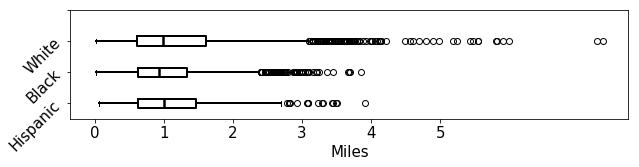

In [476]:
print ('Populations: ', 'White:', len(white), 'Black:', len(black), 'Hispanic:', len(hispanic))
print ('Total time passed: ', emergency[st+5000,2] - emergency[st,2])
print ('')
plot (white [:,0], black [:,0], hispanic [:,0])

In [398]:
len (ems_locs)

25

In [427]:
mx = 50
#still_data = ems_locs [21:26]
move_data = ems_locs #[0:21]
cluster = Cluster(grid_loc, n = 15)
#cluster.set_centers (move_data, n = len(move_data))
#cluster.remove_points (still_data)
lam = cluster.learn_lam(n_iter = 1, rand_centers = True)
#cluster.process_data_kmeans(False)
centers = cluster.get_centers()
data = cluster.get_data()

[1.6632946838691094, 701.5]


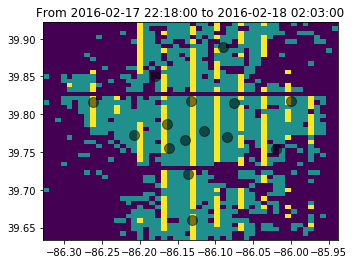

In [429]:
bincount = 50
data = grid_loc
end_time = start_time + datetime.timedelta(seconds = 15*60*interval_count)
heatmap, xedges, yedges = np.histogram2d(data[:,1], data[:,0], bins = bincount)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title ('From {} to {}'.format(str(start_time), str(end_time)))
plt.imshow(heatmap.T, extent=extent, origin='lower')
#plt.scatter(em[st:st+mx,1], em[st:st+mx,0], c = 'green', s = 100, alpha = 0.5)
plt.scatter(centers[:,1], centers[:,0], c = 'black', s= 100, alpha = 0.5)
#plt.scatter(still_data[:,1], still_data[:,0], c = 'blue', s = 100, alpha = 0.5)
#plt.scatter(ems_locs[:,1], ems_locs[:,0], c = 'red', s = 100, alpha = 0.5)
plt.show()
plt.close()